_This notebook started out as a direct iPython translation of the **M7 PDR05 Excel Spreadsheet**, implemented in a similar way as originally done by **Juande Santander-Vela** in his separate analysis of the M7 Milestone PDR05 (MS Word) document._

_This is an interactive document. **sympy** and **astropy** are required to evaluate some of the blocks of code. While overlapping in scope with "Full Computational Requirements for SDP.ipynb" and "Parametric Models of SDP Compute Requirements.ipynb", this document was independently derived._ 

_Equations may be evaluated for the different telescopes and imaging modes, either numerically or symbolically_ 

_The owner of this notebook document is **Francois Malan** of Space Advisory Company._

# 2. Load Implementation & Environment (refer to .py source files):

In [5]:
'''
The following command imports the python modules, methods and code fragments that are required to run this notebook. 
Please refer to the following python files for implementation details (omitted here for readability)
* env_setup.py -- code for setting up the python environment
* parameter_definitions.py -- contains definitions of variables, primary telescope parameters  
* formulae.py -- contains formulae for defiving secondary telescope-specific parameters from input parameters
* implementation.py -- contains methods for performing computations (i.e. crunching the numbers)
'''
from env_setup import *
from parameter_definitions_rebaselined import *
from formulae import *
from implementation_rebaselined import *

In [6]:
import time
t0 = time.time()
band = 'SKA1_Low'
mode = 'Spectral'
telescope_parameters = calc_tel_params(band=band, mode=mode)
(Tsnap_opt, Nfacet_opt) = find_optimal_Tsnap_Nfacet(telescope_parameters, verbose=True)
print (Tsnap_opt, Nfacet_opt)
#(Tsnap_opt, Nfacet_opt) = (87.16, 3)
t1 = time.time()
expression = telescope_parameters.Rflop
expression_subst = expression.subs({telescope_parameters.Tsnap : Tsnap_opt, telescope_parameters.Nfacet : Nfacet_opt})
result = evaluate_binned_expression(expression_subst, telescope_parameters)
print 'Result of expression = %f Peta' % (result)
t2 = time.time()
print 'Optimization took %f seconds' % (t1-t0)
print 'Evaluation took %f seconds' % (t2-t1)
print 'Total time = %f seconds' % (t2-t0)

Evaluating Nfacets = 1
Tsnap has been optimized as : 138.182602, yielding a minimum value of 0.000000 Peta-units
Evaluating Nfacets = 2
Tsnap has been optimized as : 198.325242, yielding a minimum value of 0.000000 Peta-units

Expression increasing with number of facets; aborting exploration of Nfacets > 2

0.000000 PetaFLOPS was the lowest FLOP value, found for (Nfacet, Tsnap) = (1, 138.18)
(138.182602346228, 1)
Result of expression = 2.946901 Peta
Optimization took 2.086369 seconds
Evaluation took 0.027069 seconds
Total time = 2.113438 seconds


# 3. Computations:

## Optimizing Tsnap and Nfacet for a given band and mode:

## Looping through a list of (standard) bands -- this may take several minutes:

In [ ]:
#selected_bands = ('Low', 'Mid1', 'Sur1')  # Only loop over the first bands for each telescope (assumed to be the most demanding)
selected_bands = ('SKA1_Low', 'SKA1_Mid', 'SKA1_Low_OLD', 'SKA1_Mid_OLD', 'SKA1_Mid_no_bl_dep', 'SKA1_Low_no_bl_dep')  # Only loop over the first bands for each telescope (assumed to be the most demanding)
selected_modes = ('Continuum', 'Spectral', 'SlowTrans')

non_peta_values = ('Npix_linear')
values_to_take_max = ('Npix_linear')

results = {}

for band in selected_bands:
    for mode in selected_modes:
        tp = calc_tel_params(band=band, mode=mode)
        print '.'
        print '>> Evaluating %s band %s in %s mode' % (tp.telescope, band, mode)
        
        (Tsnap_opt, Nfacet_opt) = find_optimal_Tsnap_Nfacet(tp)
        print 'Optimal (Tsnap, Nfacet) values = (%.2f sec, %d)' % (Tsnap_opt, Nfacet_opt)
        
        parameters = calc_tel_params(band=band, mode=mode)
        substitution = {parameters.Tsnap : Tsnap_opt, parameters.Nfacet : Nfacet_opt}
        
        expressions = (tp.Rflop_conv, tp.Rflop_fft, tp.Rflop_grid, tp.Rflop_proj, tp.Rflop_phrot, tp.Rflop, tp.Mbuf_vis, tp.Mw_cache, tp.Npix_linear, tp.Rio)
        expression_strings = ('Rflop_conv', 'Rflop_fft', 'Rflop_grid', 'Rflop_proj', 'Rflop_phrot', 'Rflop','Mbuf_vis', 'Mw_cache', 'Npix_linear', 'Rio')
        key_expressions = zip(expression_strings, expressions)
        
        for key_expression in key_expressions: 
            key = key_expression[0]
            expression = key_expression[1]
            expression_subst = expression.subs(substitution)
            take_max = (key in values_to_take_max)                
            result = evaluate_binned_expression(expression_subst, parameters, take_max=take_max)
            results[(band, mode, key)] = result
            
            if key in non_peta_values:
                print '-> %s : %s = %g' % (mode, key, result)
            else:    
                print '-> %s : %s = %.3g Peta' % (mode, key, result)
                
        #flops_total = 0
        #for key in expression_strings:
            #flops_total += results[(band, mode, key)]
        #results[(band, mode, 'Rflop')] = flops_total #This is incorrect - it is including Mbuf_vis (and likely Mw_cache too). Use explicit Rflop intead.
        #print '-> %s : %s = %.3g PetaFLOPS' % (mode, 'Rflop', flops_total/1e15)
        #print '-> %s : %s = %.3g PetaFLOPS' % (mode, 'Rflop', Rflop)
print '\n>>> Done!'

.
>> Evaluating SKA1_Low band SKA1_Low in Continuum mode
Optimal (Tsnap, Nfacet) values = (102.46 sec, 3)
-> Continuum : Rflop_conv = 0.343 Peta
-> Continuum : Rflop_fft = 0.177 Peta
-> Continuum : Rflop_grid = 0.353 Peta
-> Continuum : Rflop_proj = 0.134 Peta
-> Continuum : Rflop_phrot = 0.00197 Peta
-> Continuum : Rflop = 1.01 Peta
-> Continuum : Mbuf_vis = 0.227 Peta
-> Continuum : Mw_cache = 3.09e+10 Peta
-> Continuum : Npix_linear = 9753.01
-> Continuum : Rio = 0.00052 Peta
.
>> Evaluating SKA1_Low band SKA1_Low in Spectral mode
Optimal (Tsnap, Nfacet) values = (138.18 sec, 1)
-> Spectral : Rflop_conv = 0.698 Peta
-> Spectral : Rflop_fft = 0.839 Peta
-> Spectral : Rflop_grid = 0.81 Peta
-> Spectral : Rflop_proj = 0.6 Peta
-> Spectral : Rflop_phrot = 0 Peta
-> Spectral : Rflop = 2.95 Peta
-> Spectral : Mbuf_vis = 16.3 Peta
-> Spectral : Mw_cache = 1.31e+13 Peta
-> Spectral : Npix_linear = 16255
-> Spectral : Rio = 0.000942 Peta
.
>> Evaluating SKA1_Low band SKA1_Low in SlowTrans mo

## Because it takes a little while to compute all results, let's just dump them out to screen:

In [4]:
results

{('SKA1_Low', 'Continuum', 'Mbuf_vis'): 0.21391717395319626,
 ('SKA1_Low', 'Continuum', 'Mw_cache'): 32617092157.03457,
 ('SKA1_Low', 'Continuum', 'Npix_linear'): 9753.014912671348,
 ('SKA1_Low', 'Continuum', 'Rflop'): 0.9819988494744628,
 ('SKA1_Low', 'Continuum', 'Rflop_conv'): 0.34716423628044,
 ('SKA1_Low', 'Continuum', 'Rflop_fft'): 0.17291785836092374,
 ('SKA1_Low', 'Continuum', 'Rflop_grid'): 0.32957186844282693,
 ('SKA1_Low', 'Continuum', 'Rflop_phrot'): 0.0018569199127881617,
 ('SKA1_Low', 'Continuum', 'Rflop_proj'): 0.13048796647748395,
 ('SKA1_Low', 'Continuum', 'Rio'): 0.0004902268569760748,
 ('SKA1_Low', 'SlowTrans', 'Mbuf_vis'): 1.0175543860370559e-05,
 ('SKA1_Low', 'SlowTrans', 'Mw_cache'): 533636375.99804187,
 ('SKA1_Low', 'SlowTrans', 'Npix_linear'): 4388.856710702106,
 ('SKA1_Low', 'SlowTrans', 'Rflop'): 0.14265441795901818,
 ('SKA1_Low', 'SlowTrans', 'Rflop_conv'): 0.009062037305142967,
 ('SKA1_Low', 'SlowTrans', 'Rflop_fft'): 0.12430070803472132,
 ('SKA1_Low', 'Slow

## Now we can summarize (by summing) them for the three telescopes:

In [4]:
summable_expressions = {'Rflop_conv', 'Rflop_fft', 'Rflop_grid', 'Rflop_proj', 'Mbuf_vis', 'Rflop', 'Mw_cache', 'Rio'}
imaging_modes = {'Spectral', 'Continuum', 'SlowTrans'}

results_per_band = {}
for band in selected_bands:
    #tel = band_info[band]['telescope']
    if not band in results_per_band:
        results_per_band[band] = {}
    for expression in summable_expressions:
        if not expression in results_per_band[band]:
            results_per_band[band][expression] = 0
        for mode in imaging_modes:
            assert (band, mode, expression) in results
            results_per_band[band][expression] += results[(band, mode, expression)]

results_per_band

{'SKA1_Low': {'Mbuf_vis': 16.501572137458215,
  'Mw_cache': 13115819464034.688,
  'Rflop': 4.098237124140793,
  'Rflop_conv': 1.050259722862336,
  'Rflop_fft': 1.1405728840631855,
  'Rflop_grid': 1.17182369189955,
  'Rflop_proj': 0.7335433472590654,
  'Rio': 0.0014945351953491997},
 'SKA1_Low_OLD': {'Mbuf_vis': 237.83284402157813,
  'Mw_cache': 82242678928881.45,
  'Rflop': 37.95937490066786,
  'Rflop_conv': 10.487302629818451,
  'Rflop_fft': 10.267530332141915,
  'Rflop_grid': 10.336037513104118,
  'Rflop_proj': 6.863683941462884,
  'Rio': 0.015021617113363276},
 'SKA1_Low_no_bl_dep': {'Mbuf_vis': 30.57737483465928,
  'Mw_cache': 404184374134.596,
  'Rflop': 5.563288422929743,
  'Rflop_conv': 2.0070294262039514,
  'Rflop_fft': 0.46104730995297705,
  'Rflop_grid': 2.765145394906483,
  'Rflop_proj': 0.32087796232698784,
  'Rio': 0.004189285532722758},
 'SKA1_Mid': {'Mbuf_vis': 2.6155984430589285,
  'Mw_cache': 9362009900261.287,
  'Rflop': 13.322197458419318,
  'Rflop_conv': 2.512127340

## Let's plot the FLOP values

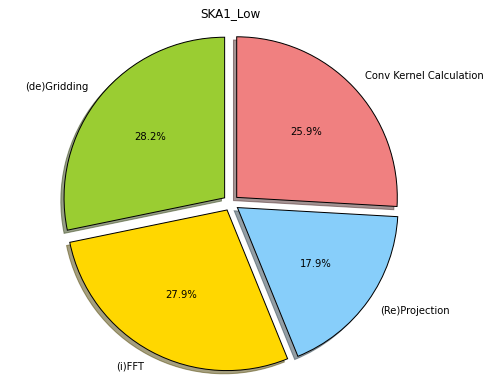

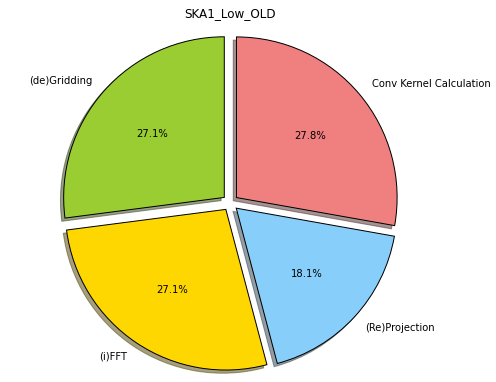

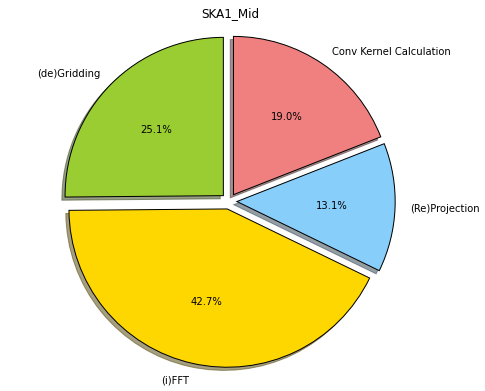

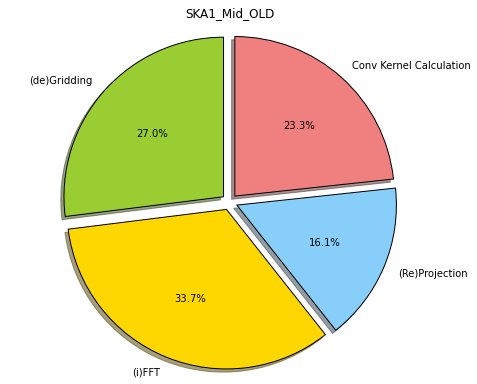

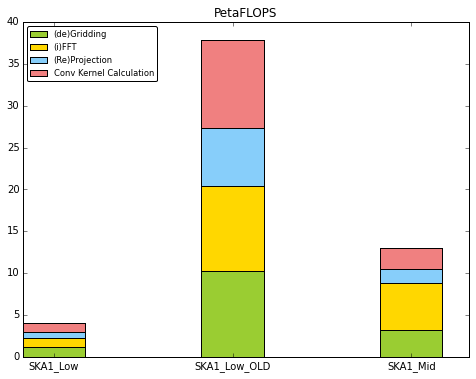

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 8, 6  # that's default image size for this interactive session

results_per_tel = results_per_band
t = results_per_tel.keys()
t.sort()
for tel in t:
    values = results_per_tel[tel]

    # The slices will be ordered and plotted counter-clockwise.
    labels = '(de)Gridding', '(i)FFT', '(Re)Projection', 'Conv Kernel Calculation'
    sizes = [values['Rflop_grid'], values['Rflop_fft'], values['Rflop_proj'], values['Rflop_conv']]
    colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
    explode = (0.05, 0.05, 0.05, 0.05) # Radial offset of the slices

    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=90)
    # Set aspect ratio to be equal so that pie is drawn as a circle.
    plt.axis('equal')
    plt.title('%s\n' % tel)

    plt.show()
    
results_per_param = {}
for tel in t:
    for param in results_per_tel[tel]:
        if not param in results_per_param:
            results_per_param[param] = []
        results_per_param[param].append(results_per_tel[tel][param])

#print results_per_param
ind = np.arange(3)

p = 'Rflop_grid'
res_grid = (results_per_tel[t[0]][p], results_per_tel[t[1]][p], results_per_tel[t[2]][p])
p = 'Rflop_fft'
res_fft = (results_per_tel[t[0]][p], results_per_tel[t[1]][p], results_per_tel[t[2]][p])
p = 'Rflop_proj'
res_proj = (results_per_tel[t[0]][p], results_per_tel[t[1]][p], results_per_tel[t[2]][p])
p = 'Rflop_conv'
res_conv = (results_per_tel[t[0]][p], results_per_tel[t[1]][p], results_per_tel[t[2]][p])

#Plot a stacked bar chart
width = 0.35
val = np.array(res_grid)
p1 = plt.bar(ind, val, width, color=colors[0])
bottoms = val
val = np.array(res_fft)
p2 = plt.bar(ind, val, width, color=colors[1],
             bottom=bottoms)
bottoms += val
val = np.array(res_proj)
p3 = plt.bar(ind, val, width, color=colors[2],
             bottom=bottoms)
bottoms += val
val = np.array(res_conv)
p4 = plt.bar(ind, val, width, color=colors[3],
             bottom=bottoms)

plt.xticks(ind+width/2., t )
plt.title('PetaFLOPS')
plt.legend(labels, loc=2) # legend upper-left